In [1]:
#Code from https://github.com/qiskit-community/ibm-quantum-challenge-spring-2023/blob/main/solutions/lab_3/lab3_solution.ipynb

In [10]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np
import bitstring

theta = np.pi/2

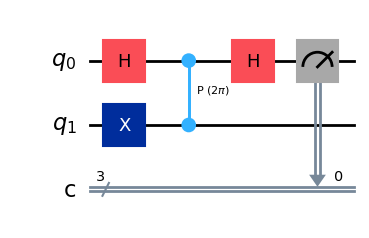

In [3]:
def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ########## your code goes here #######

    ##1 Initialization

    q0, q1 = qr
    # apply Hadamard on the auxiliary qubit
    qc.h(q0)
    # put the system qubit into the |1> state
    qc.x(q1)

    ##2 Apply control-U operator as many times as needed to get the least significant phase bit

    # we want to apply controlled-S 2^k times
    k = 2
    # calculate the angle of CPhase corresponding to 2^k applications of angle
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##3 Measure the auxiliary qubit in x-basis into the first classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    c0, _, _ = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr, theta)
qc.draw("mpl")

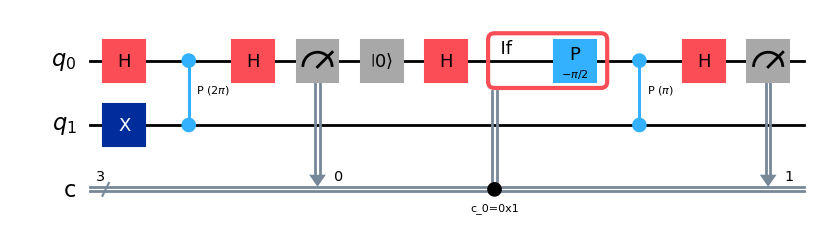

In [4]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr, angle)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1, _ = cr
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # we want to apply controlled-S 2^k times
    k = 1
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr, theta)
qc.draw("mpl")

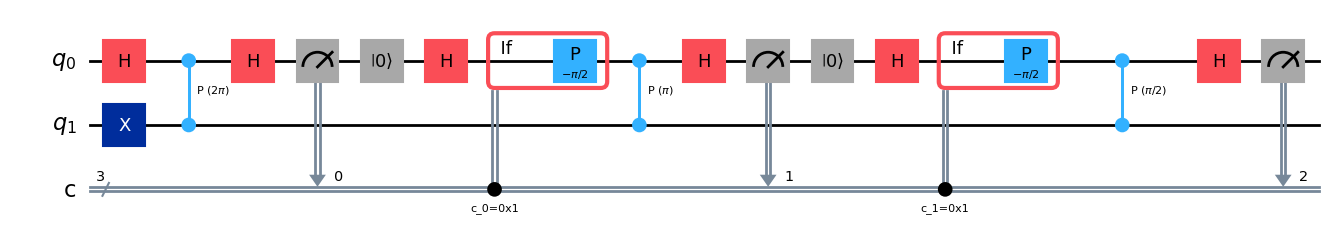

In [5]:
def step_3_circuit(qr: QuantumRegister, cr: ClassicalRegister, angle) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_2_circuit(qr, cr, angle)

    ########## your code goes here #######

    ##1 Reset and re-initialize the auxiliary qubit

    q0, q1 = qr
    # reset the auxiliary qubit
    qc.reset(q0)
    # apply Hadamard on the auxiiliary qubit
    qc.h(q0)

    ##2 Apply phase correction conditioned on the first classical bit

    c0, c1, c2 = cr
    with qc.if_test((c1, 1)):
        qc.p(-np.pi / 2, q0)

    ##3 Apply control-U operator as many times as needed to get the next phase bit

    # we want to apply controlled-S 2^k times
    k = 0
    # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
    cphase_angle = angle * 2**k
    # apply the controlled phase gate
    qc.cp(cphase_angle, q0, q1)

    ##4 Measure the auxiliary qubit in x-basis into the second classical bit

    # apply Hadamard to change to the X basis
    qc.h(q0)
    # measure the auxiliary qubit into the first classical bit
    qc.measure(q0, c2)

    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = step_3_circuit(qr, cr, theta)
qc.draw("mpl")

In [6]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'010': 1000}

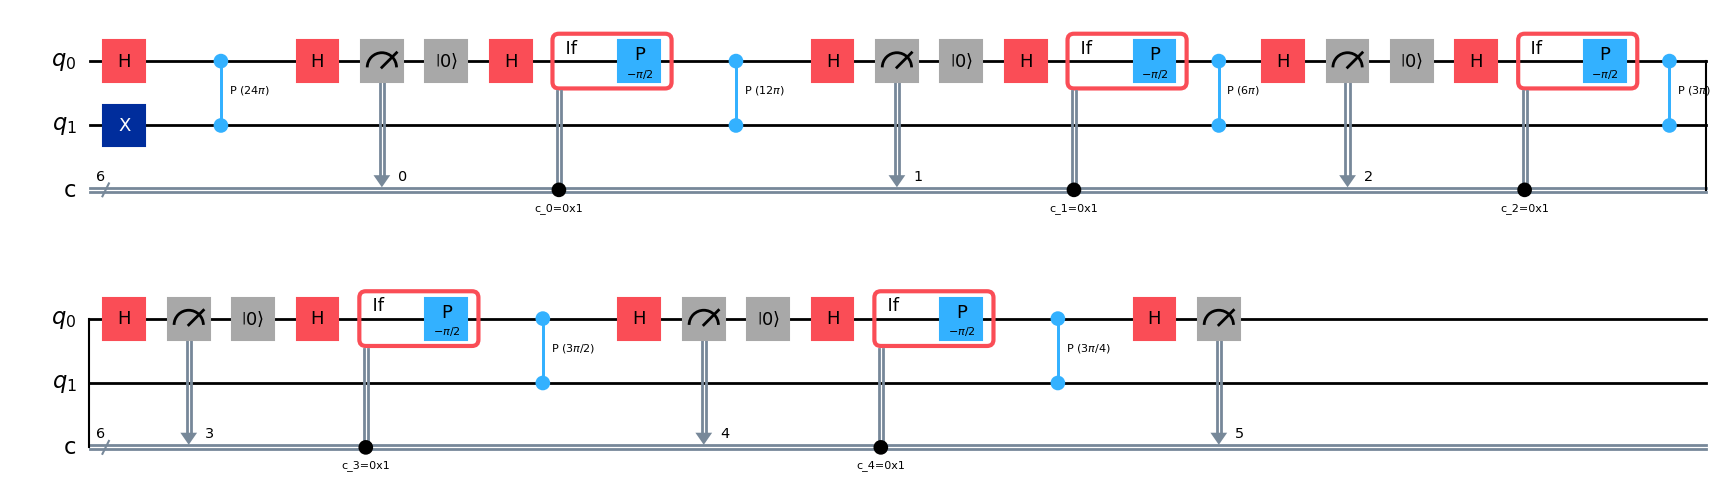

In [107]:
def iqpe(angle: float, steps: int):
    if steps == 1:
        qr = QuantumRegister(2, "q")
        cr = ClassicalRegister(3, "c")
        return step_1_circuit(qr,cr,angle)                  #funktioniert!!! (step_1_circuit will immer genau 3 classical registers haben, also zwei sind "überflüssuig", das kommt noch von mir, als ich den set_3 erweitert habe)
    else:
        qr = QuantumRegister(2,"q")
        cr = ClassicalRegister(steps, "c")
        q0, q1 = qr

        list = []
        for i in range(97, 97+steps):                               #hier die Liste mit dem Classical Register: Nachteil geht nur von A-Z, d.h. maximal 26 Steps, aber kann man theoretisch beliebig erweitern
            list.append("{:c}".format(i))
        list = cr  

        qc = QuantumCircuit(qr,cr)

        # apply Hadamard on the auxiliary qubit                                             
        qc.h(q0)
        # put the system qubit into the |1> state
        qc.x(q1)
        ##2 Apply control-U operator as many times as needed to get the least significant phase bit
        # we want to apply controlled-S 2^k times
        k = steps-1
        # calculate the angle of CPhase corresponding to 2^k applications of angle
        cphase_angle = angle * 2**k
        # apply the controlled phase gate
        qc.cp(cphase_angle, q0, q1)
        ##3 Measure the auxiliary qubit in x-basis into the first classical bit
        # apply Hadamard to change to the X basis
        qc.h(q0)
        # measure the auxiliary qubit into the first classical bit
                                 
        qc.measure(q0, list[0])                                                                                                     #Bis hier, nur step_1_cicuit

        for i in range(1,steps):                                                                                                    #Ab hier, gehts weiter über die for schleife
            qc.reset(q0)
            # apply Hadamard on the auxiiliary qubit
            qc.h(q0)

            ##2 Apply phase correction conditioned on the first classical bit

            with qc.if_test((list[i-1], 1)):
                qc.p(-np.pi / 2, q0)

            ##3 Apply control-U operator as many times as needed to get the next phase bit

            # we want to apply controlled-S 2^k times
            k = steps - i - 1
            # calculate the angle of CPhase corresponding to 2^k applications of controlled-S
            cphase_angle = angle * 2**k
            # apply the controlled phase gate
            qc.cp(cphase_angle, q0, q1)

            ##4 Measure the auxiliary qubit in x-basis into the second classical bit

            # apply Hadamard to change to the X basis
            qc.h(q0)
            # measure the auxiliary qubit into the first classical bit
            qc.measure(q0, list[i])
        
        return qc

depth = 6
angle = 0.75
theta = np.pi*angle
qc = iqpe(theta,depth)
qc.draw("mpl")

In [115]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=10000)
result = job.result()
counts = result.get_counts()
print(counts)

#test = bin(theta)

success_probability = counts["011000"] / counts.shots()          #https://www.rapidtables.com/convert/number/decimal-to-binary.html   0.7 --> 01011
print(f"Success probability: {success_probability}")

{'111000': 1433, '011000': 8567}
Success probability: 0.8567
